In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#read the input drug-metabolite data
data = pd.read_csv('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\data\\Paclitaxel_metabolic_NCI.csv')
data.head(2)

,Cell Line,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,...,O-b-D-glucopyranosyl-(1->3)-O-2-(acetylamino)-2-deoxy-b-D-glucopyranosyl-(1->3)-O-[6-deoxy-a-L-galactopyranosyl-(1->4)]-O-b-D-galactopyranosyl-(1->4)-O-[6-deoxy-a-L-galactopyranosyl-(1->3)]-D-Glucose,LS tetrasaccharide d ; Sialyllacto-N-neotetraose c ; Sialyllacto-N-tetraose a ; Sialyllacto-N-tetraose b ; Sialyllacto-N-tetraose c,PIP2(16:0/18:0) ; PIP2(18:0/16:0),"TG(22:5(7Z,10Z,13Z,16Z,19Z)/20:5(5Z,8Z,11Z,14Z,17Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso6] ; TG(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))[iso3]","(2E)-Hexadecenoyl-CoA ; 2,7,10-hexadecatrienoylcoa ; 3,7,10-hexadecatrienoylcoa ; 3Z,7Z,10Z-hexadecatrienoyl-CoA ; 4,7,10-hexadecatrienoylcoa ; 4Z,7Z,10Z-hexadecatrienoyl-CoA ; 7,10,13-hexadecatrienoylcoa ; trans,cis,cis-2,7,10-hexadecatrienoyl-CoA",Lacto-N-difucohexaose ; Lacto-N-difucopentaose II,Galabiosylceramide (d18:1/26:1(17Z)) ; Lactosylceramide (d18:1/26:1(17Z)),cells,Cell names,Paclitaxel
0,Breast_BT549,0.021811,0.006137,1.801231,0.178675,0.031762,0.143416,0.004437,0.001118,0.002353,...,0.036367,0.025836,0.075427,0.036502,0.019935,0.032820,0.039391,BT549,BR:BT-549,5.573385
1,Breast_HS578T,0.010611,0.006815,0.884542,0.093390,0.016027,0.037372,NaN,0.005778,0.003199,...,0.024981,0.013982,0.054200,0.029125,0.010750,0.015981,0.035154,HS578T,BR:HS 578T,6.502923


In [3]:
#drop the target drug column
drug = data.pop('Paclitaxel')

In [4]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()

In [5]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')
X = X[rep_meta]

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [6]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [7]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [8]:
X.shape, y.shape

((52, 197), (52,))

In [9]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

0    29
1    23
dtype: int64

In [10]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [11]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,1.527898,-0.152672,-0.853410,-0.808484,0.125542,-0.635081,0.177249,-0.464199,-0.435396,0.739494,...,-1.061594,-0.991825,-0.390663,-1.160363,0.837350,-1.217592,-0.356111,0.332057,-0.692077,1.013794
1,-0.258146,0.587812,-0.495271,-0.184964,0.663440,-0.339764,-1.173327,-1.060564,-1.099125,1.267567,...,-0.675788,-0.205860,-1.091873,0.006127,-0.891447,-1.074953,-1.047278,-1.986310,-1.565694,0.661397


In [12]:
X.shape, y.shape

((58, 197), (58,))

In [13]:
y.value_counts()

1    29
0    29
dtype: int64

In [14]:
X.shape

(58, 197)

In [15]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [16]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    
    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 67
Number of features selected during iteration 1: 71
Number of features selected during iteration 2: 73
Number of features selected during iteration 3: 75
Number of features selected during iteration 4: 64
Number of features selected during iteration 5: 62
Number of features selected during iteration 6: 69
Number of features selected during iteration 7: 75
Number of features selected during iteration 8: 70
Number of features selected during iteration 9: 62
Number of features selected during iteration 10: 67
Number of features selected during iteration 11: 71
Number of features selected during iteration 12: 65
Number of features selected during iteration 13: 69
Number of features selected during iteration 14: 68
Number of features selected during iteration 15: 71
Number of features selected during iteration 16: 76
Number of features selected during iteration 17: 68
Number of features selected during iteration 18: 65
Number of features sel

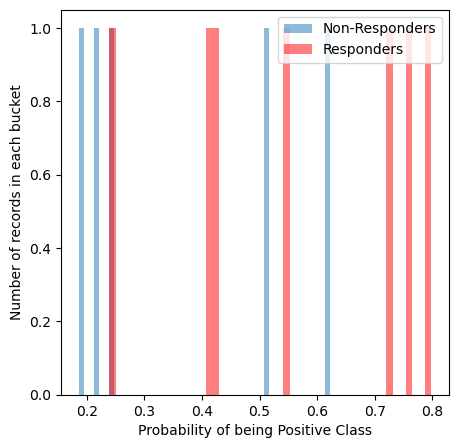

In [17]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5, bins = 50)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [18]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [19]:
df1

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.527898,-0.152672,-0.853410,-0.808484,0.125542,-0.635081,0.177249,-0.464199,-0.435396,0.739494,...,-0.390663,-1.160363,0.837350,-1.217592,-0.356111,0.332057,-0.692077,1.013794,NaN,NaN
1,-0.258146,0.587812,-0.495271,-0.184964,0.663440,-0.339764,-1.173327,-1.060564,-1.099125,1.267567,...,-1.091873,0.006127,-0.891447,-1.074953,-1.047278,-1.986310,-1.565694,0.661397,NaN,NaN
2,0.997340,0.916345,-1.153536,-0.450718,0.608830,-0.753931,0.720712,0.674368,0.630516,-0.549611,...,0.030720,-1.019315,-0.118893,-1.101284,-0.214360,-0.487442,-0.578295,-0.241803,NaN,NaN
3,-1.444513,-1.415917,0.864094,0.812620,1.192095,-0.526184,0.271887,1.675295,1.768933,-0.658571,...,-0.133284,-0.291327,0.354363,0.236080,-0.304636,-0.748304,0.572622,-0.796670,NaN,NaN
4,-1.469623,-0.025317,-0.508693,0.298282,-1.321398,-0.749501,-0.847851,-0.187618,-0.546970,-0.792136,...,-1.176452,0.259513,-1.603352,1.173335,-1.971553,-0.594966,-1.091181,-0.100656,NaN,NaN
5,-0.096263,-0.025317,-0.685310,-0.173280,-0.000610,-0.413527,1.163758,0.781167,0.445570,1.713346,...,-0.409903,0.494102,0.082465,0.715955,-1.339294,1.050489,0.609373,-1.043483,0.186533,0.0
6,0.002870,-1.621068,-0.288081,0.438176,-0.512686,-0.170363,-1.268971,-0.669710,-0.816644,0.141537,...,-0.572551,-0.900627,-0.362391,0.236720,0.209857,-0.772440,-0.413557,1.618584,0.621733,0.0
7,-2.063871,-0.025317,0.334783,0.009306,-0.075023,-0.273697,-0.730398,-1.251737,-1.425982,1.647732,...,-1.969257,-0.771902,-2.057508,0.842020,-1.555915,-1.176382,-1.007299,-1.373142,NaN,NaN
8,-0.841360,-0.430431,-0.864731,-1.264871,0.604393,-0.841101,0.069369,1.273112,1.618224,-0.254773,...,0.180225,-1.079748,-0.037937,-0.807908,-0.359068,0.066697,0.232766,-0.002052,NaN,NaN
9,2.563746,-1.151341,-0.067056,0.598960,0.252800,-0.629352,0.196135,0.139945,0.202120,0.283724,...,0.028975,-1.091946,0.587726,-0.139229,0.480215,0.038678,0.227207,0.534049,NaN,NaN


In [20]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(2, 199)

In [21]:
df1_main.index.values #0 40 41 42

array([19, 41], dtype=int64)

In [22]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define the model
model2 = SVC(C=1, gamma=1, probability=True)

#define a list to store accuracy, precision and recall 
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    
    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 69
Features selected during iteration 1: 66
Features selected during iteration 2: 71
Features selected during iteration 3: 75
Features selected during iteration 4: 71
Features selected during iteration 5: 63
Features selected during iteration 6: 74
Features selected during iteration 7: 73
Features selected during iteration 8: 66
Features selected during iteration 9: 69
Features selected during iteration 10: 66
Features selected during iteration 11: 73
Features selected during iteration 12: 73
Features selected during iteration 13: 77
Features selected during iteration 14: 63
Features selected during iteration 15: 71
Features selected during iteration 16: 69
Features selected during iteration 17: 71
Features selected during iteration 18: 68
Features selected during iteration 19: 73
Features selected during iteration 20: 75
Features selected during iteration 21: 75
Features selected during iteration 22: 68
Features selected during iteration 23: 70
Fe

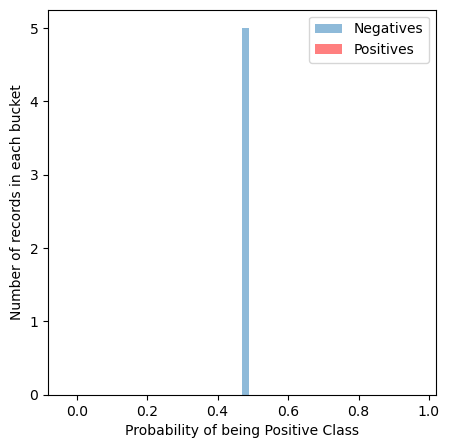

In [23]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [24]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [25]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
13,-0.399202,0.298655,-0.576731,2.536586,-0.044553,-0.408321,-1.025842,-0.030311,-0.241348,0.169002,...,0.668272,0.957331,0.189641,-0.058223,1.426907,0.040007,0.398200,-0.886066,0.468992,1.0
19,1.613250,-1.741446,-1.253808,-0.917107,0.215105,-1.203110,0.153450,0.511132,0.709527,-1.211655,...,-0.053781,-1.080153,-0.359018,-1.059150,-0.257169,-0.075928,-0.460939,0.682557,0.468992,1.0
41,0.260170,0.098258,-0.352363,-0.364482,1.828728,0.088651,0.330780,0.852149,1.175960,0.044959,...,2.115624,0.544066,1.427087,-0.554010,-0.340893,1.776942,1.159315,-0.233803,0.525863,1.0
42,1.022366,0.901900,0.359678,-0.836590,1.175731,0.372130,2.129334,2.271988,3.098601,-0.804165,...,1.600166,-0.947132,1.731211,0.069709,0.687619,1.015011,1.378193,1.502656,0.468992,1.0


In [26]:
df2_main.index.values #40 41 42

array([13, 19, 41, 42], dtype=int64)

In [27]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#define the model
model3 = XGBClassifier()

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    
    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 29
Features selected during iteration 1: 29
Features selected during iteration 2: 29
Features selected during iteration 3: 29
Features selected during iteration 4: 29
Features selected during iteration 5: 29
Features selected during iteration 6: 29
Features selected during iteration 7: 29
Features selected during iteration 8: 29
Features selected during iteration 9: 29
Features selected during iteration 10: 29
Features selected during iteration 11: 29
Features selected during iteration 12: 29
Features selected during iteration 13: 29
Features selected during iteration 14: 29
Features selected during iteration 15: 29
Features selected during iteration 16: 29
Features selected during iteration 17: 29
Features selected during iteration 18: 29
Features selected during iteration 19: 29
Features selected during iteration 20: 29
Features selected during iteration 21: 29
Features selected during iteration 22: 29
Features selected during iteration 23: 29
Fe

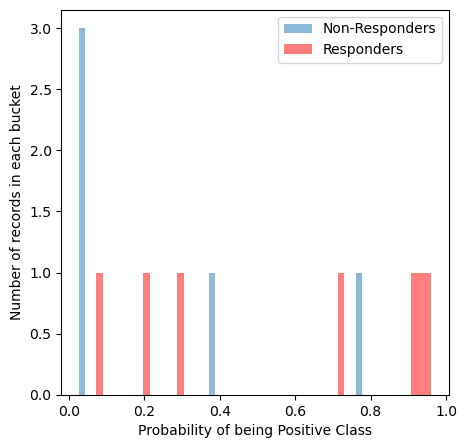

In [28]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [29]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,1.527898,-0.152672,-0.853410,-0.808484,0.125542,-0.635081,0.177249,-0.464199,-0.435396,0.739494,...,-0.390663,-1.160363,0.837350,-1.217592,-0.356111,0.332057,-0.692077,1.013794,NaN,NaN
1,-0.258146,0.587812,-0.495271,-0.184964,0.663440,-0.339764,-1.173327,-1.060564,-1.099125,1.267567,...,-1.091873,0.006127,-0.891447,-1.074953,-1.047278,-1.986310,-1.565694,0.661397,NaN,NaN
2,0.997340,0.916345,-1.153536,-0.450718,0.608830,-0.753931,0.720712,0.674368,0.630516,-0.549611,...,0.030720,-1.019315,-0.118893,-1.101284,-0.214360,-0.487442,-0.578295,-0.241803,NaN,NaN
3,-1.444513,-1.415917,0.864094,0.812620,1.192095,-0.526184,0.271887,1.675295,1.768933,-0.658571,...,-0.133284,-0.291327,0.354363,0.236080,-0.304636,-0.748304,0.572622,-0.796670,NaN,NaN
4,-1.469623,-0.025317,-0.508693,0.298282,-1.321398,-0.749501,-0.847851,-0.187618,-0.546970,-0.792136,...,-1.176452,0.259513,-1.603352,1.173335,-1.971553,-0.594966,-1.091181,-0.100656,NaN,NaN
5,-0.096263,-0.025317,-0.685310,-0.173280,-0.000610,-0.413527,1.163758,0.781167,0.445570,1.713346,...,-0.409903,0.494102,0.082465,0.715955,-1.339294,1.050489,0.609373,-1.043483,0.027098,0.0
6,0.002870,-1.621068,-0.288081,0.438176,-0.512686,-0.170363,-1.268971,-0.669710,-0.816644,0.141537,...,-0.572551,-0.900627,-0.362391,0.236720,0.209857,-0.772440,-0.413557,1.618584,0.775807,0.0
7,-2.063871,-0.025317,0.334783,0.009306,-0.075023,-0.273697,-0.730398,-1.251737,-1.425982,1.647732,...,-1.969257,-0.771902,-2.057508,0.842020,-1.555915,-1.176382,-1.007299,-1.373142,NaN,NaN
8,-0.841360,-0.430431,-0.864731,-1.264871,0.604393,-0.841101,0.069369,1.273112,1.618224,-0.254773,...,0.180225,-1.079748,-0.037937,-0.807908,-0.359068,0.066697,0.232766,-0.002052,NaN,NaN
9,2.563746,-1.151341,-0.067056,0.598960,0.252800,-0.629352,0.196135,0.139945,0.202120,0.283724,...,0.028975,-1.091946,0.587726,-0.139229,0.480215,0.038678,0.227207,0.534049,NaN,NaN


In [30]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
41,0.260170,0.098258,-0.352363,-0.364482,1.828728,0.088651,0.330780,0.852149,1.175960,0.044959,...,2.115624,0.544066,1.427087,-0.554010,-0.340893,1.776942,1.159315,-0.233803,0.911503,1.0
42,1.022366,0.901900,0.359678,-0.836590,1.175731,0.372130,2.129334,2.271988,3.098601,-0.804165,...,1.600166,-0.947132,1.731211,0.069709,0.687619,1.015011,1.378193,1.502656,0.931271,1.0


In [31]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [32]:
cl = set(common_list)
cl

{13, 19, 41, 42}

In [33]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,Isopropyl alcohol ; Propyl alcohol,But-2-enoic acid ; Diacetyl ; Gamma-Butyrolactone ; Oxolan-3-one,2-Aminoacrylic acid ; 2-aminoacrylic acid,D-Proline ; D-proline ; L-Proline ; L-proline ; acetamidopropanal,5-Aminopentanoic acid ; Betaine ; HMDB02141 ; L-Valine ; L-valine ; Vaporole ; glycine betaine,"Erythrono-1,4-lactone ; Methylmalonate ; Methylmalonic acid ; Succinate ; Succinic acid ; Threonolactone",Aminomalonic acid,1-Pyrroline-4-hydroxy-2-carboxylate ; 5-oxoprolinate ; HMDB01843 ; L-1-Pyrroline-3-hydroxy-5-carboxylate ; Pyroglutamic acid ; Pyrrolidonecarboxylic acid ; Pyrroline hydroxycarboxylic acid,4-acetamidobutanal ; D-Pipecolic acid ; HMDB04226 ; L-Pipecolic acid ; L-pipecolic acid ; Pipecolic acid,(S)-2-Acetolactate ; 2-Acetolactate ; Dimethylmalonic acid ; Ethylmalonic acid ; Glutaric acid ; Methylsuccinic acid ; Monoethyl malonic acid,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
13,-0.399202,0.298655,-0.576731,2.536586,-0.044553,-0.408321,-1.025842,-0.030311,-0.241348,0.169002,...,0.668272,0.957331,0.189641,-0.058223,1.426907,0.040007,0.398200,-0.886066,0.239467,1.0
19,1.613250,-1.741446,-1.253808,-0.917107,0.215105,-1.203110,0.153450,0.511132,0.709527,-1.211655,...,-0.053781,-1.080153,-0.359018,-1.059150,-0.257169,-0.075928,-0.460939,0.682557,0.760533,1.0
22,0.387809,-0.025317,2.487804,-0.724087,-0.122666,0.196217,0.938937,0.701603,0.543663,-1.282195,...,-0.084552,-0.257829,0.080891,2.671805,0.490264,0.250531,0.535941,0.880912,0.409067,1.0
41,0.260170,0.098258,-0.352363,-0.364482,1.828728,0.088651,0.330780,0.852149,1.175960,0.044959,...,2.115624,0.544066,1.427087,-0.554010,-0.340893,1.776942,1.159315,-0.233803,0.728933,1.0
42,1.022366,0.901900,0.359678,-0.836590,1.175731,0.372130,2.129334,2.271988,3.098601,-0.804165,...,1.600166,-0.947132,1.731211,0.069709,0.687619,1.015011,1.378193,1.502656,0.547733,1.0
50,-1.531261,-0.133696,-0.740422,-0.547052,0.612023,-0.538428,-1.351180,1.797371,1.162952,0.181664,...,0.228664,0.294664,0.180684,0.119398,-0.249109,0.601054,1.187221,0.786116,0.418400,1.0


In [34]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\master_list_metabolomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')

In [35]:
l = []
l.extend(df1_total.index.values)
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\total_metabolomics.txt', 'a+') as f:
    for i in l:
        f.write(f'{i}\n')